### Name: Umair Hussain
### UTORID: hussa906


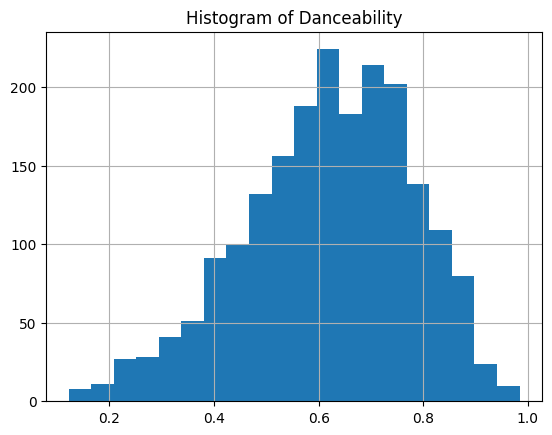

In [3]:
import numpy as np
import pandas as pd
import pymc as pm
import matplotlib.pyplot as plt

# Read the CSV file into a DataFrame
df = pd.read_csv('data.csv')

column_data = df['danceability']

# Convert the column data to a NumPy array
x = np.array(column_data.values)

# Histogram of "danceability"
df.hist(column = "danceability", bins=20)
plt.title('Histogram of Danceability')

theta_0,tau = 0,1; alpha,beta = 2,1/2 # Initialize Prior Hyperparameters: specify prior distributions

# Initialize the normal_gamma_model
normal_gamma_model = pm.Model()
with normal_gamma_model:
    theta = pm.Normal("theta", mu=theta_0, sigma=tau)
    phi = pm.Gamma("phi", alpha=alpha, beta=beta)
    x_obs = pm.Normal("likelihood", mu=theta, sigma=1/phi**0.5, observed=x)

We can see from the above histogram that the column data above is relatively normally distributed

In [ ]:
with normal_gamma_model:
    idata_HMC = pm.sample() # default is the NUTS implementation of HMC

HMC Split-Rhats {'theta': 1.0024, 'phi': 1.0044} | 

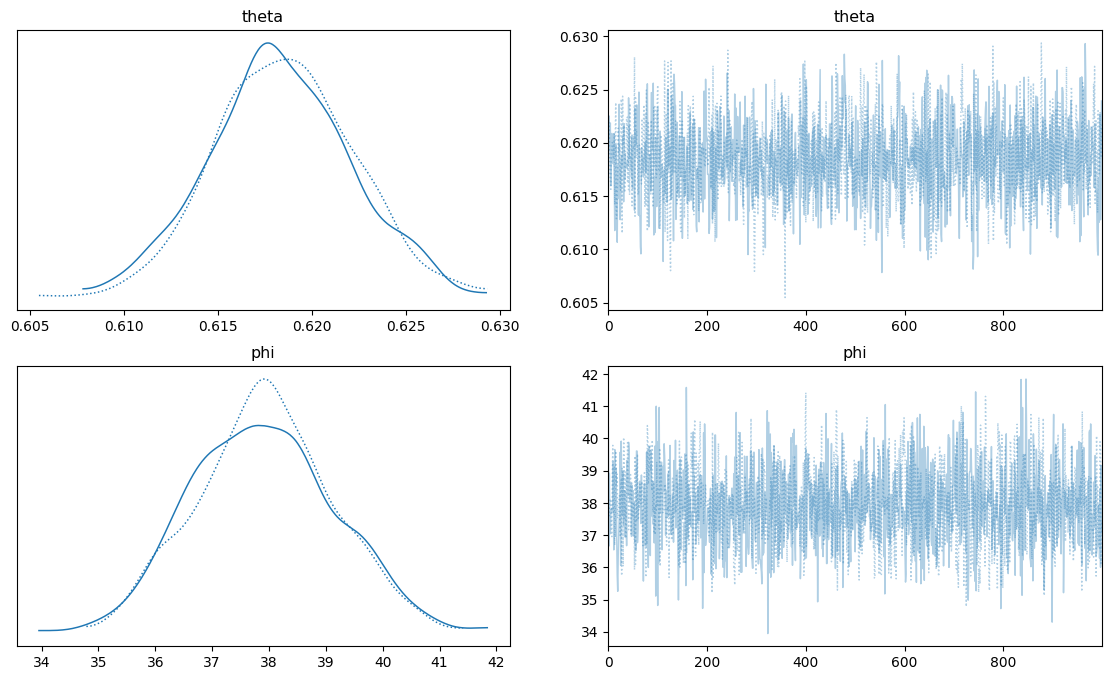

In [ ]:
import arviz as az; import matplotlib.pyplot as plt; fig,ax = plt.subplots(2,2, figsize=(14,8))
az.plot_trace(idata_HMC, axes=ax[:2,:2])
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(idata_HMC).items()}, end=' | ')
# Values close to 1 so converges

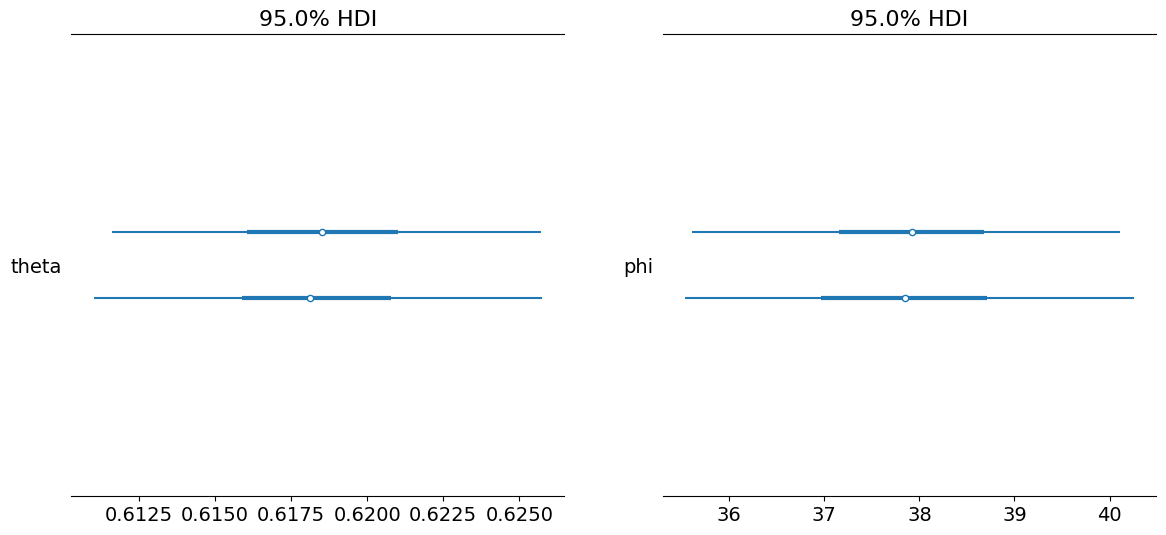

In [ ]:
import arviz as az; import matplotlib.pyplot as plt; fig,ax = plt.subplots(1,2, figsize=(14,6))
az.plot_forest(idata_HMC, var_names=["theta"], combined=False, hdi_prob=0.95, ax=ax[0]);
az.plot_forest(idata_HMC, var_names=["phi"], combined=False, hdi_prob=0.95, ax=ax[1]);

This script performs Bayesian inference on the "danceability" data from a CSV file. After loading the data into a DataFrame, it extracts the "danceability" column and converts it into a NumPy array. A histogram of the "danceability" values is plotted to visualize the data distribution.

Next, the script initializes a Bayesian model with normal-gamma priors for parameters "theta" and "phi" using PyMC. It then samples from the posterior distribution using Hamiltonian Monte Carlo HMC implemented in PyMC.

After sampling, trace plots are generated to examine the convergence and mixing of the MCMC chains. The split-Rhat statistic is calculated and printed, indicating good convergence of the chains as the values are close to 1.

Finally, forest plots are created to visualize the posterior distributions of parameters "theta" and "phi" along with their 95% highest density intervals HDIs. These plots provide insights into the estimated values and uncertainties associated with the parameters obtained from the Bayesian analysis.

## Part 2/3 - Non Normal Data
I use the acousticness

In [ ]:
non_normal_column_data = df['acousticness']

# Convert the column data to a NumPy array
ac = np.array(non_normal_column_data.values)

# Initialize the normal_gamma_model
beta_model = pm.Model()
with beta_model:
    alpha = pm.Exponential("alpha", lam=1)
    beta = pm.Exponential("beta", lam=1)
    likelihood = pm.Beta("likelihood", alpha=alpha, beta=beta, observed=ac)

In [ ]:
with beta_model:
    idata_HMC = pm.sample() # default is the NUTS implementation of HMC

HMC Split-Rhats {'alpha': 1.0013, 'beta': 0.9994} | 

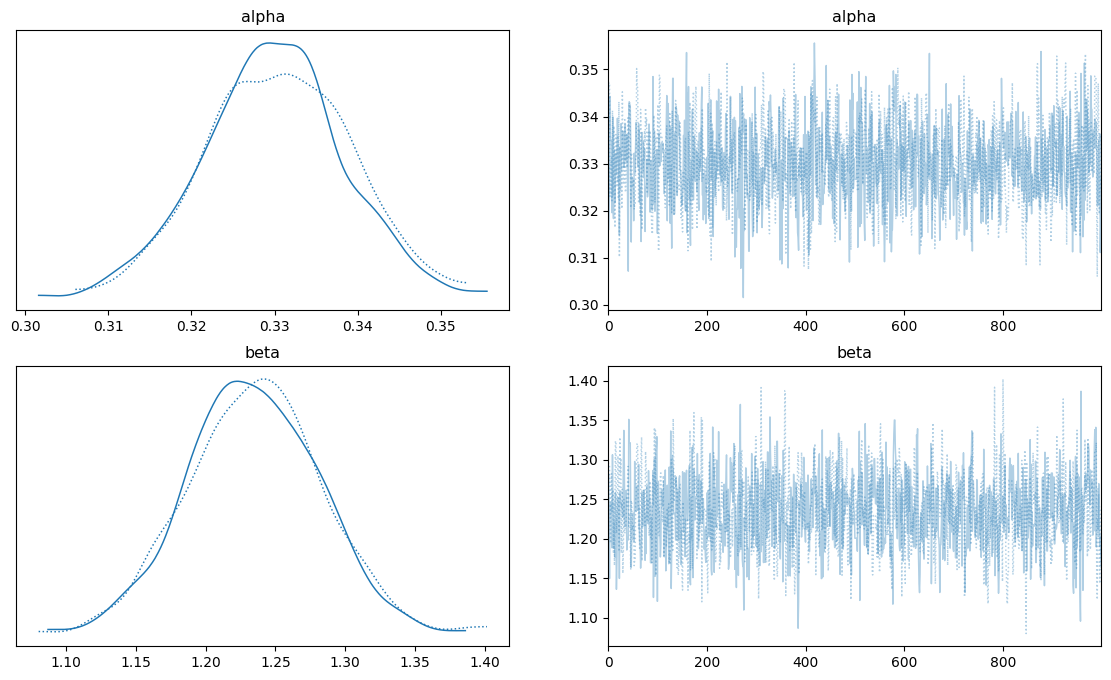

In [ ]:
import arviz as az; import matplotlib.pyplot as plt; fig,ax = plt.subplots(2,2, figsize=(14,8))
az.plot_trace(idata_HMC, axes=ax[:2,:2])
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(idata_HMC).items()}, end=' | ')

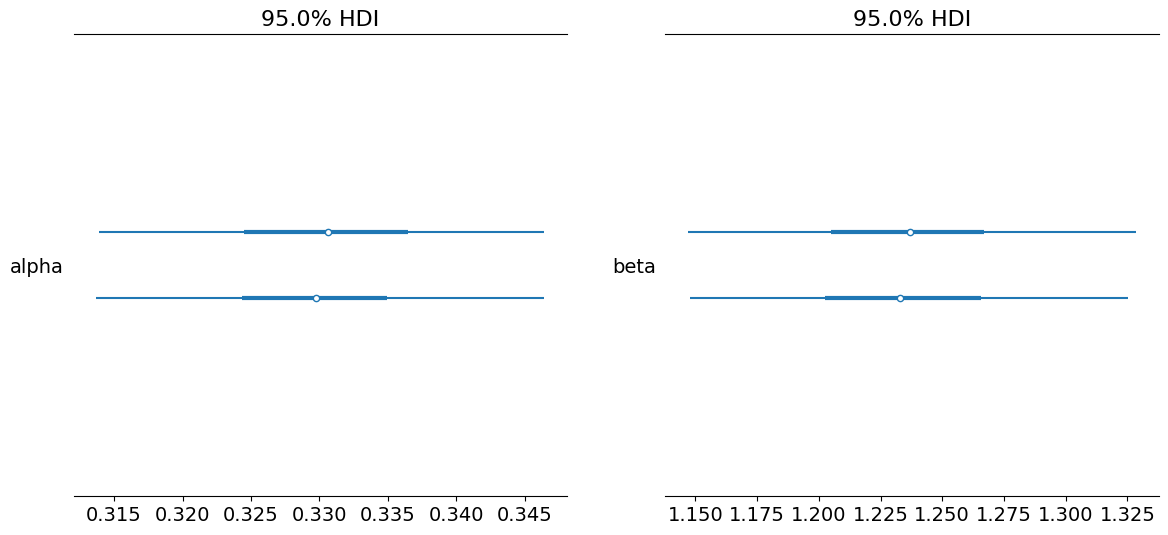

In [ ]:
import arviz as az; import matplotlib.pyplot as plt; fig,ax = plt.subplots(1,2, figsize=(14,6))
az.plot_forest(idata_HMC, var_names=["alpha"], combined=False, hdi_prob=0.95, ax=ax[0]);
az.plot_forest(idata_HMC, var_names=["beta"], combined=False, hdi_prob=0.95, ax=ax[1]);


This code generates two forest plots using ArviZ, displaying the posterior distributions of parameters "alpha" and "beta" along with their 95% highest density intervals HDIs. The first subplot depicts the forest plot for "alpha," while the second subplot shows the forest plot for "beta." These plots offer a concise visual summary of parameter estimates and associated uncertainties from our Bayesian analysis.

### Part 4 MCMC Chain Analysis

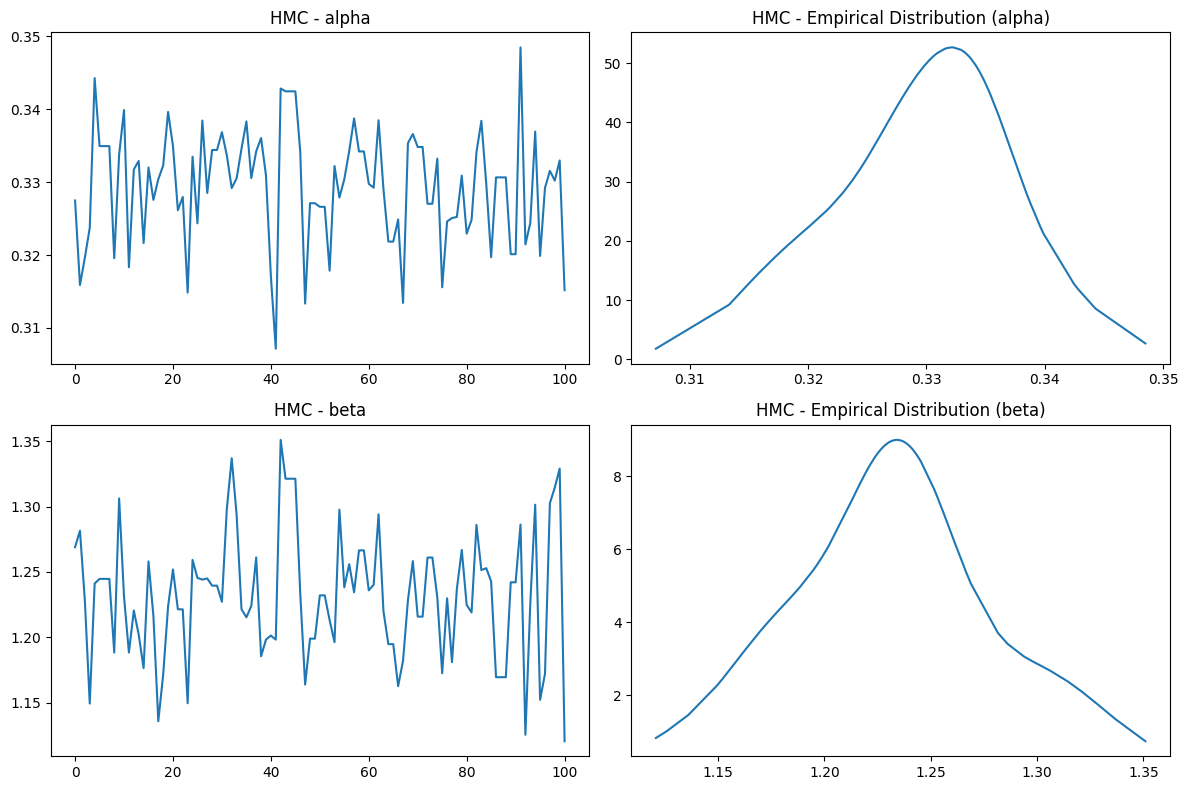

In [ ]:
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

n_mcmc_samples = 100

# Create a figure with subplots
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# Loop over parameters "alpha" and "beta"
for i, parameter in enumerate(["alpha", "beta"]):
    # Extract MCMC samples
    mcmc_chain = idata_HMC.posterior[parameter].sel(chain=0, draw=slice(0, n_mcmc_samples)).values
    mcmc_chain_sorted = sorted(mcmc_chain)

    # Plot raw MCMC samples
    ax[i, 0].plot(mcmc_chain)
    ax[i, 0].set_title(f"HMC - {parameter}")

    # Plot MCMC samples with empirical distribution
    ax[i, 1].plot(mcmc_chain_sorted, gaussian_kde(mcmc_chain_sorted)(mcmc_chain_sorted))
    ax[i, 1].set_title(f"HMC - Empirical Distribution ({parameter})")

plt.tight_layout()
plt.show()

Autocorrelation for HMC (MCMC) chain - alpha: 0.19997801649482827
Autocorrelation for HMC (MCMC) chain - beta: 0.18690478949601216


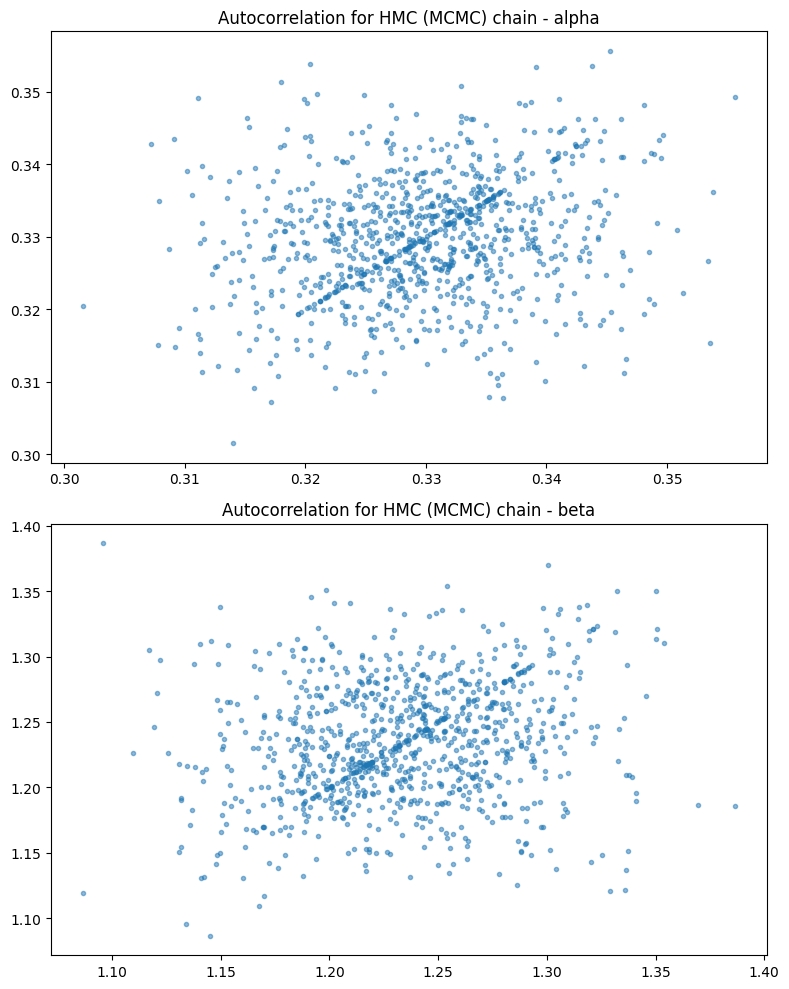

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(8, 10))

# Parameters
max_mcmc_samples = 1000
parameters = ["alpha", "beta"]

for i, parameter in enumerate(parameters):
    # Extract MCMC samples
    mcmc_chain = idata_HMC.posterior[parameter].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values
    mcmc_chain_one_step_ahead = idata_HMC.posterior[parameter].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values

    # Plot autocorrelation
    ax[i].plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5)
    ax[i].set_title(f"Autocorrelation for HMC (MCMC) chain - {parameter}")

    # Calculate and print autocorrelation
    autocorr = np.corrcoef(mcmc_chain, mcmc_chain_one_step_ahead)[0, 1]
    print(f"Autocorrelation for HMC (MCMC) chain - {parameter}: {autocorr}")

plt.tight_layout()
plt.show()

The autocorrelation analysis examines the relationship between consecutive samples in MCMC chains, crucial for understanding the correlation structure within the chain and assessing its impact on inference. For both parameters "alpha" and "beta", we plotted the autocorrelation between consecutive MCMC samples. With a maximum of 1000 samples considered, we observed moderate autocorrelation for both parameters, with values around 0.2 for "alpha" and "beta" chains. The plots illustrate the relationship between current and next-step samples, providing insights into the persistence of values over successive iterations. These autocorrelation values, while indicating some dependence between samples, remain within acceptable bounds, ensuring the reliability of the MCMC chains for inference purposes.

In [ ]:
import arviz as az;
print("number of MCMC samples:", idata_HMC.posterior['alpha'].values.flatten().shape[-1])
print("number of MCMC samples:", idata_HMC.posterior['beta'].values.flatten().shape[-1])
az.summary(idata_HMC, round_to=2)

number of MCMC samples: 2000
number of MCMC samples: 2000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.33,0.01,0.31,0.35,0.0,0.0,1360.37,1319.19,1.0
beta,1.24,0.05,1.15,1.32,0.0,0.0,1251.71,1301.58,1.0


The effective sample size quantifies the number of independent samples in an MCMC chain. With autocorrelation values around 0.2 for both "alpha" and "beta" chains, our analysis yielded ESS values of approximately 1360.37 and 1251.71 for "alpha" and "beta", respectively, using bulk autocorrelation, and 1319.19 and 1301.58 using tail autocorrelation. These relatively high ESS values suggest that despite moderate autocorrelation, the MCMC chains capture sufficient independent information for inference. While autocorrelation reduces ESS by incorporating redundant information, the observed ESS values indicate robustness in our inference for both parameters.

Overall, these analyses aid in evaluating the convergence, mixing, and autocorrelation properties of the MCMC chains, essential for ensuring the reliability of Bayesian inference results.